<a href="https://colab.research.google.com/github/JuneSHYoo/monitory-ml/blob/main/Feature_Engineering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

import warnings
warnings.filterwarnings('ignore')

Mounted at /content/drive


In [2]:
########################
###   데이터셋 불러오기   ###
########################

import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/Factoreal/train_equips_data.csv',encoding='utf-8-sig', header=0)

In [5]:
########################
###   파생변수 생성     ###
########################
import numpy as np


# 1. 설비별 센서 변화량 및 rolling
for col in ['active_power', 'reactive_power', 'temperature', 'pressure', 'vibration', 'humidity']:
    df[f'{col}_diff'] = df.groupby('equipment')[col].diff().fillna(0)
    df[f'{col}_rollmean'] = df.groupby('equipment')[col].rolling(window=5, min_periods=1).mean().reset_index(level=0, drop=True)
    df[f'{col}_rollstd'] = df.groupby('equipment')[col].rolling(window=5, min_periods=1).std().reset_index(level=0, drop=True).fillna(0)

# 2. 역률 파생변수 (전체에서 계산해도 무방)
ap = df['active_power']
rp = df['reactive_power']
df['power_factor'] = ap / np.sqrt(ap**2 + rp**2)
df['power_factor'] = df['power_factor'].fillna(0)

# 4. 범주형 인코딩
if 'label_elec' in df.columns:
    df['label_elec'] = df['label_elec'].astype('category').cat.codes


df.dtypes

,0
temperature,float64
pressure,float64
vibration,float64
humidity,float64
equipment,object
faulty,float64
active_power,float64
reactive_power,float64
label_elec,int8
event,bool


In [7]:
## RUL 구간별 COUNT

target_col = 'rul'
bins = np.arange(0, df[target_col].max()+5, 2)
rul_bins = pd.cut(df[target_col], bins=bins)

bin_counts = rul_bins.value_counts().sort_index()
print(bin_counts)
print(bin_counts.min())

rul
(0, 2]      2092
(2, 4]      1388
(4, 6]       934
(6, 8]       605
(8, 10]      416
(10, 12]     271
(12, 14]     198
(14, 16]     135
(16, 18]      84
(18, 20]      53
(20, 22]      38
(22, 24]      23
(24, 26]      14
(26, 28]       8
(28, 30]       3
(30, 32]       2
(32, 34]       1
(34, 36]       0
Name: count, dtype: int64
0


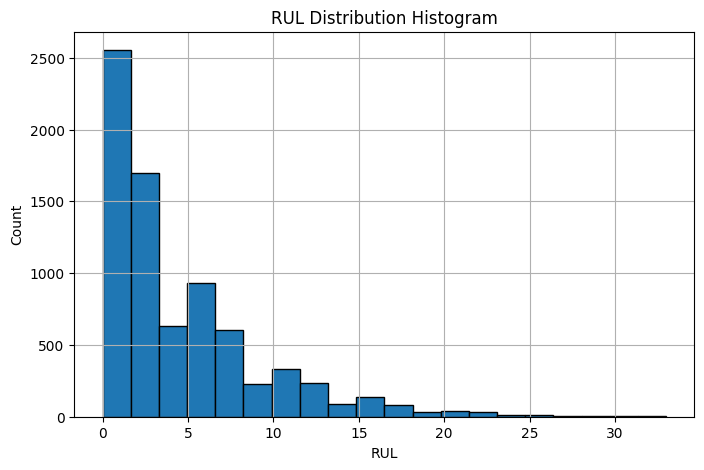

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.hist(df['rul'], bins=20, edgecolor='black')  # bins 개수는 데이터에 따라 조절 가능
plt.title('RUL Distribution Histogram')
plt.xlabel('RUL')
plt.ylabel('Count')
plt.grid(True)
plt.show()

In [31]:
## 구간별 샘플링

# 1. 구간 생성 (3씩)
bin_width = 2
max_rul = int(np.ceil(df['rul'].max()))
bins = list(range(0, max_rul + bin_width, bin_width))
if bins[-1] < max_rul + 1:
    bins.append(max_rul + 1)  # 혹시 최대값 포함 안되면 추가

# # 2. 구간 라벨 생성
labels = [f'{bins[i]}-{bins[i+1]}' for i in range(len(bins)-1)]

# # 3. pd.cut으로 구간 나누기
df['rul_bin'] = pd.cut(df['rul'], bins=bins, labels=labels, right=False)

# # 4. 구간별 ratio 직접 지정 (원하는 대로!)
# # 아래는 예시, 실제 데이터 분포 보고 직접 값 바꿔도 됨
# # 구간 수에 따라 아래 딕셔너리의 길이 조절 필요!
oversample_ratio = {
    labels[0]: 1,   # 0-2
    labels[1]: 1,   # 2-4
    labels[2]: 3,   # 4-6
    labels[3]: 3,   # 6-8
    labels[4]: 8,   # 8-10
    labels[5]: 10,   # 10-12
    labels[6]: 10,   # 12-14
    labels[7]: 15,   # 14-16
    labels[8]: 20,   # 16-18, ... 마지막 구간
    labels[9]: 20,   # -20
    labels[10]:20,   # -22
    labels[11]:20,   # -24
    labels[12]:20
    # ... 필요시 더 추가!
}
# 구간이 더 많거나 적다면 oversample_ratio를 늘리거나 줄여주세요.

# 5. 구간별로 배수만큼 데이터 복제
dfs = []
for label in labels:
    bin_df = df[df['rul_bin'] == label]
    n_rep = oversample_ratio.get(label, 1)  # 없는 구간은 1배로
    if len(bin_df) > 0 and n_rep > 0:
        dfs.append(pd.concat([bin_df]*n_rep, ignore_index=True))

# 6. 데이터 합치고, bin 컬럼 삭제
balanced_df = pd.concat(dfs).reset_index(drop=True)
balanced_df = balanced_df.drop(columns=['rul_bin'])

# 7. 구간별 데이터 개수 확인 (선택)
print(balanced_df['rul'].groupby(pd.cut(balanced_df['rul'], bins=bins)).count())

rul
(0, 2]      2092
(2, 4]      2654
(4, 6]      2802
(6, 8]      3185
(8, 10]     3700
(10, 12]    2710
(12, 14]    2420
(14, 16]    2335
(16, 18]    1680
(18, 20]    1060
(20, 22]     760
(22, 24]     460
(24, 26]     166
(26, 28]       8
(28, 30]       3
(30, 32]       2
(32, 34]       1
Name: rul, dtype: int64


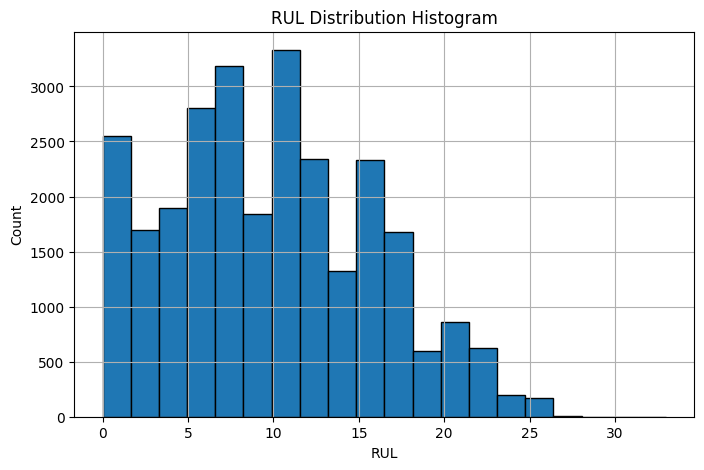

In [32]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.hist(balanced_df['rul'], bins=20, edgecolor='black')  # bins 개수는 데이터에 따라 조절 가능
plt.title('RUL Distribution Histogram')
plt.xlabel('RUL')
plt.ylabel('Count')
plt.grid(True)
plt.show()

In [20]:
balanced_df.columns

Index(['temperature', 'pressure', 'vibration', 'humidity', 'equipment',
       'faulty', 'active_power', 'reactive_power', 'label_elec', 'event',
       'rul', 'active_power_diff', 'active_power_rollmean',
       'active_power_rollstd', 'reactive_power_diff',
       'reactive_power_rollmean', 'reactive_power_rollstd', 'temperature_diff',
       'temperature_rollmean', 'temperature_rollstd', 'pressure_diff',
       'pressure_rollmean', 'pressure_rollstd', 'vibration_diff',
       'vibration_rollmean', 'vibration_rollstd', 'humidity_diff',
       'humidity_rollmean', 'humidity_rollstd', 'power_factor'],
      dtype='object')

In [33]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from lightgbm import LGBMRegressor
from lightgbm import early_stopping, log_evaluation
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

feature_cols = [
    'temperature', 'pressure', 'vibration', 'humidity',
       'active_power', 'reactive_power',
      #  'active_power_diff',
        'active_power_rollmean', 'active_power_rollstd',
      #  'reactive_power_diff',
     'reactive_power_rollmean', 'reactive_power_rollstd',
      'power_factor',
    # 'temperature_diff',
       'temperature_rollmean', 'temperature_rollstd',
    # 'pressure_diff',
       'pressure_rollmean', 'pressure_rollstd',
    # 'vibration_diff',
       'vibration_rollmean', 'vibration_rollstd',
    # 'humidity_diff',
       'humidity_rollmean', 'humidity_rollstd',
    'equipment'
    # 'label_elec', 'equipment','faulty'
]
target_col = 'rul'

cat_cols = ['equipment']
for col in cat_cols:
    balanced_df[col] = balanced_df[col].astype('category')

df_sub = balanced_df[balanced_df['rul'] < 25].copy()

# 데이터셋 분리
X = df_sub[feature_cols]
y = df_sub[target_col]
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_temp, y_temp, test_size=0.2, random_state=42)


# train, test split 후에
# y_train_log = np.log1p(y_train)
# y_valid_log = np.log1p(y_valid)
# y_test_log = np.log1p(y_test)


# LGBM 모델 정의 및 학습
model = LGBMRegressor(
    n_estimators=100,
    learning_rate=0.05,
    random_state=42
)

# LightGBM은 eval_set 인자와 callbacks로 로그 찍기
model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_valid, y_valid)],
    eval_names=['train', 'valid'],
    eval_metric='rmse',
    # categorical_feature=cat_cols,
    callbacks=[
        log_evaluation(period=10),          # 10번마다 로그 출력
        early_stopping(stopping_rounds=30)  # 30회 연속 성능 향상 없으면 멈춤
    ]
)

# 추가: evals_result_로 로그 직접 저장 (LightGBM v3 이상)
evals_result = model.evals_result_
print(evals_result)

# 예측 및 성능 확인
y_pred = model.predict(X_test)
# y_pred = np.expm1(y_pred_log)  # 원래 스케일로 역변환
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2  = r2_score(y_test, y_pred)
print(f"RMSE: {mse**0.5:.2f} | MAE: {mae:.2f} | R2: {r2:.4f}")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007225 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4849
[LightGBM] [Info] Number of data points in the train set: 17449, number of used features: 20
[LightGBM] [Info] Start training from score 9.712075
Training until validation scores don't improve for 30 rounds
[10]	train's rmse: 5.43577	train's l2: 29.5476	valid's rmse: 5.39064	valid's l2: 29.059
[20]	train's rmse: 5.08516	train's l2: 25.8588	valid's rmse: 5.08248	valid's l2: 25.8317
[30]	train's rmse: 4.81156	train's l2: 23.1511	valid's rmse: 4.83981	valid's l2: 23.4238
[40]	train's rmse: 4.59858	train's l2: 21.147	valid's rmse: 4.6476	valid's l2: 21.6002
[50]	train's rmse: 4.40993	train's l2: 19.4475	valid's rmse: 4.48005	valid's l2: 20.0708
[60]	train's rmse: 4.25092	train's l2: 18.0703	valid's rmse: 4.33725	valid's l2: 18.8117
[70]	train's rmse: 4.10814	train's l2: 16.8768	valid's rmse: 4.211

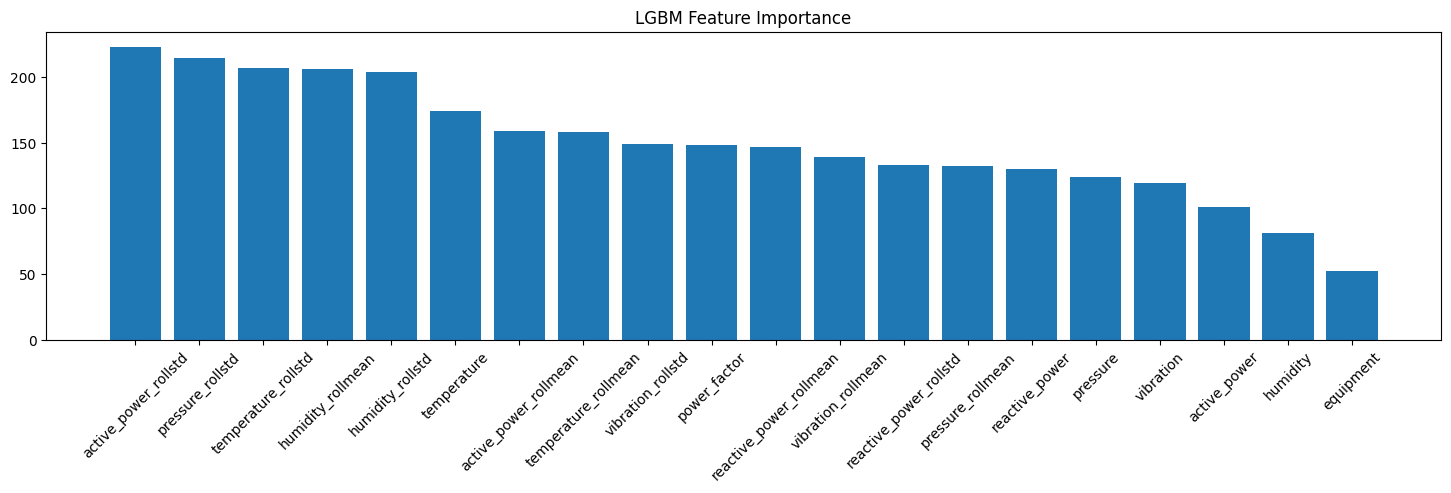

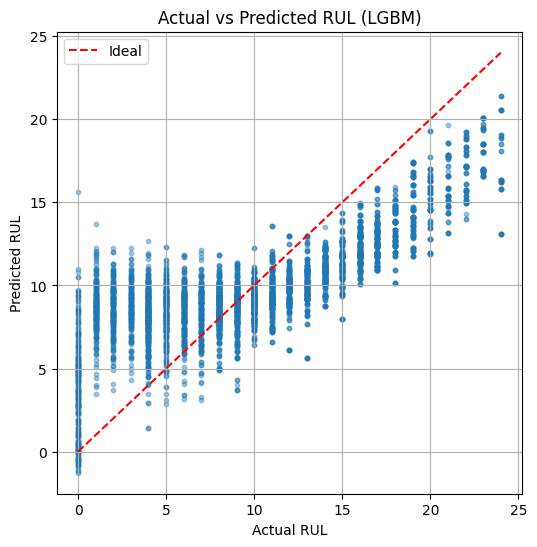

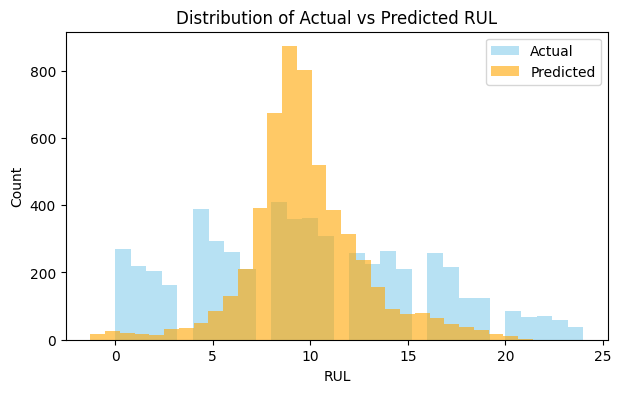

In [34]:
# Feature Importance
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(18,4))
sorted_idx = np.argsort(model.feature_importances_)[::-1]
plt.bar(np.array(feature_cols)[sorted_idx], model.feature_importances_[sorted_idx])
plt.xticks(rotation=45)
plt.title('LGBM Feature Importance')
plt.show()

###

import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, s=10, alpha=0.4)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Ideal')  # 대각선
plt.xlabel("Actual RUL")
plt.ylabel("Predicted RUL")
plt.title("Actual vs Predicted RUL (LGBM)")
plt.legend()
plt.grid(True)
plt.show()

###


plt.figure(figsize=(7, 4))
plt.hist(y_test, bins=30, alpha=0.6, label='Actual', color='skyblue')
plt.hist(y_pred, bins=30, alpha=0.6, label='Predicted', color='orange')
plt.xlabel("RUL")
plt.ylabel("Count")
plt.title("Distribution of Actual vs Predicted RUL")
plt.legend()
plt.show()